# **Partial-RAINBOW DQN**

This notebook is the final implementation of Partial-Rainbow DQN that combines four of the improvements to the oringinal DQN algorithm proposed by DeepMind.

The improvements that we are combining are

1. Adding a Dueling Architecture (https://arxiv.org/pdf/1511.06581.pdf)
2. Improving Q-Value estimation using Double Q Learning(https://arxiv.org/pdf/1509.06461.pdf)
3. Improving sampling efficiency using a Prioritized Replay Buffer(https://arxiv.org/pdf/1511.05952.pdf)

## Libraries Imported

1. ``gym, numpy, random and math`` are used to inteact with the environment
2. ``skimage`` is used to preprocess and transform the images
3. ``torch`` related libraries are used to construct the Dueling Double DQN

In [ ]:
# Import all gym related libraries
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Take action
import random
import math

# define libraries to pre-process image
from skimage import transform
from skimage.color import rgb2gray

# Create a pytorch DQN
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [ ]:
# determine if a gpu is available to accelerate the computations
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
print("Device chosen ",device)

Device chosen  cuda


## Define the environment

At present we are choosing the to play space-invaders. The reason is that it is a fairly complex game with a good reward distribution to chart the performance of our models.

In [ ]:
# Define the Show state function
env = gym.make('SpaceInvaders-v0')
observation_space = env.observation_space
action_space = env.action_space
# Print observation space is 
print("Observation Space is :",observation_space)
print("Number of actions is :",action_space.n)

Observation Space is : Box(210, 160, 3)
Number of actions is : 6


## Define the preprocessing functions

In [ ]:
def process_frame(frame) :

    # 1. convert image from rgb to gray
    gray_image = rgb2gray(frame)

    # 2. Crop the image
    cropped_image = gray_image[0:-12,4:-12]

    # 3. Normalized frame
    normalized_frame = cropped_image / 255.0

    # 4. Resize
    resize_image = transform.resize(normalized_frame,[110,84])

    return resize_image

In [ ]:
def create_frame_stack(frame,existing_stack,max_len=16) :

    # 1. Create processed frame
    processed_frame = process_frame(frame)

    # 2. append it to the stack
    existing_stack.append(processed_frame)

    # 3. if length of stack exceeds 4 then remove the last one
    if len(existing_stack) > max_len :
        existing_stack = existing_stack[1:]
    
    # 4. create a numpy array
    #np_frame = np.array(existing_stack)
    np_frame = np.array([existing_stack[15],existing_stack[10],existing_stack[5],existing_stack[1]])

    return np_frame, existing_stack

In [ ]:
# Create an empty stack
def create_new_stack(name_env) :
    new_stack = list()
    for _ in range(16) :
        new_stack.append(np.zeros((110,84),dtype=np.int))
    return new_stack

In [ ]:
def compute_n_step_return(rewards) :
    cumulative = 0.0
    gamma = 0.95
    for r in reversed(rewards) :
        cumulative = cumulative*gamma + r
    return cumulative

In [ ]:
def n_step_discount_reward(rewards) :
    n_step = 2
    N = len(rewards)
    discounted_rewards = list()
    for i in range(len(rewards)) :
        limit = min(i + n_step,N)
        cumulative = compute_n_step_return(rewards[i:limit])
        discounted_rewards.append(cumulative)
    return discounted_rewards

## Create the Normal and Priority Buffers

Here we are defining the Buffers both Standard and Prioritized (https://arxiv.org/pdf/1511.05952.pdf).

In a nutshell you need to know is that all our experiences (stacks of image frames) are stored in a python List/Queue and whereas a normal buffer samples randomly, the Prioritized Buffer samples using a probability weights which are defined according to the paper refered above.

In [ ]:
# Create a buffer
class Buffer(object) :
    def __init__(self,max_size) :
        self.max_size = max_size
        self.buffer = list()
    
    def add(self,experience) :
        self.buffer.append(experience)
        #self.probabilities.append(max(self.probabilities,default=1))
        self.resize()
        
    def resize(self) :
        n = max(len(self.buffer) - self.max_size,0)
        while n > 0 :
            self.buffer.pop(0)
            n -= 1
        

    def sample(self,batch_size) :
        sample_size = min(len(self.buffer),batch_size)

        random_perm_list = np.random.permutation(len(self.buffer)).tolist()
        random_perm_list = random_perm_list[:sample_size]

        return [self.buffer[i] for i in random_perm_list]

    def __len__(self) :
        return len(self.buffer)

In [ ]:
# Create a buffer
class PERBuffer :
    def __init__(self,max_size) :
        self.max_size = max_size
        self.buffer = list()
        self.probabilities = list()
    
    def add(self,experience) :
        self.buffer.append(experience)
        self.probabilities.append(max(self.probabilities,default=1))
        #print(len(self.probabilities))
        self.resize()
        
    def resize(self) :
        n = max(len(self.buffer) - self.max_size,0)
        while n > 0 :
            self.buffer.pop(0)
            self.probabilities.pop(0)
            n -= 1

    def get_proabilities(self,alpha=1) :
        np_probs = np.array(self.probabilities) ** alpha
        sample_probs = np_probs / np_probs.sum()
        return sample_probs

    def get_importance(self,sample_probs,indexes,beta=1) :
        N = self.max_size # right now instead of N being a variying number, I am using a constant N
        importance_weights = list()
        for i in indexes :
            importance_weights.append(1.0/sample_probs[i])
        
        np_importance = np.array(importance_weights)/N
        np_importance_normalized = (np_importance ** beta) / np.max(np_importance)
        return np_importance_normalized

    def set_priorities(self,indexes,error) :
        offset = 0.1
        for i in range(len(indexes)) :
            self.probabilities[indexes[i]] = error[i] + offset

    def sample(self,batch_size) :
        sample_size = min(len(self.buffer),batch_size)
        sample_probs = self.get_proabilities(1)
        
        random_perm_list = np.random.choice(np.arange(len(self.buffer)),size=sample_size,p=sample_probs).tolist()
        importance = self.get_importance(sample_probs,random_perm_list,1)

        return [self.buffer[i] for i in random_perm_list], random_perm_list, importance

## Define the DQN and Dueling DQN

In this section we define the following architectures :

1. Deep Q-Network
2. Dueling Deep Q-Network


Note : We are still developing the Noisy Layer, however it is not cetain that it will work, however you can play around to fix it.

In [ ]:
# Define Noisy Layer
class NoisyLinear(nn.Module):
    """Noisy linear module for NoisyNet.
    
    Attributes:
        in_features (int): input size of linear module
        out_features (int): output size of linear module
        std_init (float): initial std value
        weight_mu (nn.Parameter): mean value weight parameter
        weight_sigma (nn.Parameter): std value weight parameter
        bias_mu (nn.Parameter): mean value bias parameter
        bias_sigma (nn.Parameter): std value bias parameter
        
    """

    def __init__(self, in_features: int, out_features: int, std_init: float = 0.5):
        """Initialization."""
        super(NoisyLinear, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init

        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.weight_sigma = nn.Parameter(
            torch.Tensor(out_features, in_features)
        )
        self.register_buffer(
            "weight_epsilon", torch.Tensor(out_features, in_features)
        )

        self.bias_mu = nn.Parameter(torch.Tensor(out_features))
        self.bias_sigma = nn.Parameter(torch.Tensor(out_features))
        self.register_buffer("bias_epsilon", torch.Tensor(out_features))

        self.reset_parameters()
        self.reset_noise()

    def reset_parameters(self):
        """Reset trainable network parameters (factorized gaussian noise)."""
        mu_range = 1 / math.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(
            self.std_init / math.sqrt(self.in_features)
        )
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(
            self.std_init / math.sqrt(self.out_features)
        )

    def reset_noise(self):
        """Make new noise."""
        epsilon_in = self.scale_noise(self.in_features)
        epsilon_out = self.scale_noise(self.out_features)

        # outer product
        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
        self.bias_epsilon.copy_(epsilon_out)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation.
        
        We don't use separate statements on train / eval mode.
        It doesn't show remarkable difference of performance.
        """
        return F.linear(
            x,
            self.weight_mu + self.weight_sigma * self.weight_epsilon,
            self.bias_mu + self.bias_sigma * self.bias_epsilon,
        )
    
    @staticmethod
    def scale_noise(size: int) -> torch.Tensor:
        """Set scale to make noise (factorized gaussian noise)."""
        x = torch.FloatTensor(np.random.normal(loc=0.0, scale=1.0, size=size))

        return x.sign().mul(x.abs().sqrt())

In [ ]:
# 4.1 DQN
class DQN(nn.Module) :
    def __init__(self,actions_size) :
        super(DQN,self).__init__()

        self.actions_size = actions_size
        self.conv1 = nn.Conv2d(4,20,(4,4),4)
        self.pool1 = nn.MaxPool2d(4,1)

        self.conv2 = nn.Conv2d(20,32,(2,2),2)
        self.pool2 = nn.MaxPool2d((2,2),1)


        self.linear = nn.Linear(32*11*8,512)
        self.noisy_layer = NoisyLinear(512,512)
        self.linear2 = nn.Linear(512,actions_size)

    def forward(self,x,use_noisy=False) :

        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        
        x = x.view(-1,32*11*8)
        
        
        x = self.linear(x)
        if use_noisy :
            x = self.noisy_layer(x)
            
        x = F.relu(x)
        x = self.linear2(x)

        return x
    
    def reset_noise(self) :
        self.noisy_layer.reset_noise()

In [ ]:
# This now implements the Dueling Architecture
class DuelingDQN(nn.Module) :
    def __init__(self,actions_size) :
        super(DuelingDQN,self).__init__()

        self.actions_size = actions_size
        self.conv1 = nn.Conv2d(4,20,(4,4),4)
        self.pool1 = nn.MaxPool2d(4,1)

        self.conv2 = nn.Conv2d(20,32,(2,2),2)
        self.pool2 = nn.MaxPool2d((2,2),1)

        self.linear = nn.Linear(32*11*8,512)
        self.noisy_layer = NoisyLinear(512,512)

        self.linear2 = nn.Linear(512,actions_size)

        self.adv_layer = nn.Linear(actions_size,actions_size)
        self.val_layer = nn.Linear(actions_size,1)

    def forward(self,x,use_noisy=False) :

        batch_size = x.size(0)

        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        
        x = x.view(-1,32*11*8)
        x = self.linear(x)

        if use_noisy :
            x = self.noisy_layer(x)
        x = F.relu(x)

        x = self.linear2(x)

        x = F.relu(x)

        # This is the Addition of the Dueling DQN Architecture
        advantage = self.adv_layer(x)

        value = self.val_layer(x).expand(batch_size,self.actions_size)

        complete_q_vals = value + advantage - advantage.mean(1).unsqueeze(1).expand(batch_size,self.actions_size)
        
        return complete_q_vals
    
    def reset_noise(self) :
        self.noisy_layer.reset_noise()

## Defining Agents

In this section we are defining agent that will collect experience and will learn from them.
We created the agent to be as modular as possible so that one can train the various settings

In [ ]:
# 5.1 There is one agent and it is called agent, rest extentions are additional features
class Agent(object) :

    def __init__(self,env,
                 use_per=False,
                 use_double_learning=False,
                 use_dueling_architecture=False,
                 use_n_step_learning=False,
                 use_noisy=False) :
        
        self.env = env
        self.use_per = use_per 
        self.use_double_learning = use_double_learning 
        self.use_dueling_architecture = use_dueling_architecture
        self.use_n_step_learning = use_n_step_learning
        self.use_noisy = use_noisy

        if self.use_per :
            self.existing_buffer = PERBuffer(1000)
        else :
            self.existing_buffer = Buffer(1000)
        
        self.fill_up_buffer(100)
        
        if self.use_dueling_architecture :
            self.dqn = DuelingDQN(env.action_space.n)
            self.dqn = self.dqn.to(device)
            
            self.target_dqn = DuelingDQN(env.action_space.n)
            self.target_dqn = self.target_dqn.to(device)
            self.target_dqn.load_state_dict(self.dqn.state_dict())

        else :
            self.dqn = DQN(env.action_space.n)
            self.dqn = self.dqn.to(device)
            self.target_dqn = DQN(env.action_space.n)
            self.target_dqn = self.target_dqn.to(device)
            self.target_dqn.load_state_dict(self.dqn.state_dict())

        self.criterion = F.smooth_l1_loss
        self.optimizer = optim.Adam(self.dqn.parameters(),lr=1e-7)
        self.loss_list = list()
        self.total_rewards = list()
        self.epsilon = 1.0
        self.epsilon_list = list()
        self.tau = 1e-3
        self.total_episodes = 500

    # 5.1 Define the fill up buffer
    # Fill up the buffer
    def fill_up_buffer(self,num_exp) :
        existing_stack = create_new_stack('SpaceInvaders-v0')
        # collect all examples randomly
        state = self.env.reset()
        state, existing_stack = create_frame_stack(state,existing_stack)
        experience_list = list()
        rewards_list = list()
        step = 0
        prev_action = action_space.sample()
        num_lives = env.ale.lives()
        for ex in range(num_exp) :
            
            if step % 4 == 0 :
                action = action_space.sample()
            else :
                action = prev_action
                
            next_state, reward, done, info = self.env.step(action)
            
            lives_remaining = env.ale.lives()
            if lives_remaining < num_lives :
                done = True
                num_lives = lives_remaining
            
            # Introduce Reward Clipping here also
            reward = max(reward,1) # get a positive reward if survived
            reward = max(reward,4) # Get additional points for a hit
            
            if done :
                next_state = np.zeros((210,160,3),dtype=np.int)
                next_state, existing_stack = create_frame_stack(next_state,existing_stack)

                experience_list.append((state,action,next_state,done))
                rewards_list.append(-2)
                
                # Now create the n-step rewards_list
                discounted_rewards = n_step_discount_reward(rewards_list)

                # Now append every 13th item to the experience buffer
                # I need to add the i + n the next_state
                N = len(experience_list)
                n_step = 2
                print("explen : ",N)
                for i in range(0,len(experience_list) - n_step,13) :
                    
                    if self.use_n_step_learning :
                        
                        # Use TD(n)
                        s, a, _, _ = experience_list[i]
                        limit = min(i + n_step,N-1)
                        _, _, ns, d = experience_list[limit]
                        r = discounted_rewards[i]
                    else :
                         # Use normal TD(0)
                         s, a, ns, d = experience_list[i]
                         r = rewards_list[i]

                    self.existing_buffer.add((s,a,r,ns,d))
                    
                    state = self.env.reset()
                    existing_stack = create_new_stack('SpaceInvaders-v0')
                    state, existing_stack = create_frame_stack(state,existing_stack)
                    
            else :
                next_state, existing_stack = create_frame_stack(next_state,existing_stack)
                
                experience_list.append((state,action,next_state,done))
                rewards_list.append(reward)
                
                state = next_state
            step += 1

    # 5.2 Define the take_action
    def take_action(self,state,epsilon) :
        epsilon = max(epsilon,0.1)
        prob = random.uniform(0,1)
        if prob < epsilon :
            # Take Action based on Random Probability
            action = action_space.sample()
        else :
            # Take Action based on Q-values
            batch_state = np.array([state])
            torch_state = Variable(torch.from_numpy(batch_state)).type(torch.float)
            torch_state = torch_state.to(device)
            with torch.no_grad() :
                if self.use_noisy :
                    q_vals = self.dqn(torch_state,True)
                else :
                    q_vals = self.dqn(torch_state)

            action = q_vals.max(1)[1].item()
        
        return action
    
    # 5.3 Define the train function
    def train(self,batch_size,gamma) :
        # This is the train loop, where I combine all the learning steps
        # 1. get all lists
        states_list = list()
        actions_list = list()
        rewards_list = list()
        next_states_list = list()
        dones_list = list()
        if self.use_per :
            batch, indexes, importance = self.existing_buffer.sample(batch_size)
        else :
            batch = self.existing_buffer.sample(batch_size)

        
        for item in batch :
            state, action, reward, next_state, done = item
            states_list.append(state)
            actions_list.append(action)
            rewards_list.append(reward)
            next_states_list.append(next_state)
            
            if done :
                dones_list.append(0)
            else :
                dones_list.append(1)
                
        # Convert all list objects into numpy arrays
        np_states = np.asarray(states_list)
        np_actions = np.asarray(actions_list)
        np_next_states = np.asarray(next_states_list)
        np_dones = np.asarray(dones_list)
        np_rewards = np.asarray(rewards_list)
        
        # Convert all the numpy arrays into torch tensors
        torch_states = Variable(torch.from_numpy(np_states)).type(torch.float)
        torch_actions = Variable(torch.from_numpy(np_actions)).type(torch.LongTensor)
        torch_next_state = Variable(torch.from_numpy(np_next_states)).type(torch.float)
        torch_dones = Variable(torch.from_numpy(np_dones)).type(torch.long)
        torch_rewards = Variable(torch.from_numpy(np_rewards)).type(torch.long)
        

        # transfer tensors to device
        torch_states = torch_states.to(device)
        torch_actions = torch_actions.to(device)
        torch_next_state = torch_next_state.to(device)
        torch_dones = torch_dones.to(device)
        torch_rewards = torch_rewards.to(device)
        
        # Predict Q-values from the Policy/Actor
        if self.use_noisy :
            all_q_vals = self.dqn(torch_states,True)
        else :
            all_q_vals = self.dqn(torch_states)
        
        pred_q_val = all_q_vals.gather(1,torch_actions.unsqueeze(1)).squeeze(1)
        
        # below should be a target dqn, next q vals are estimated using our own DQN, and also we compute 
        if self.use_double_learning :
            with torch.no_grad() :
                if self.use_noisy :
                    next_state_q_vals = self.dqn(torch_next_state,True).detach()
                    next_state_target_q_vals = self.target_dqn(torch_next_state,True)
                else :
                    next_state_q_vals = self.dqn(torch_next_state).detach()
                    next_state_target_q_vals = self.target_dqn(torch_next_state)
            
            # Next state actions are estimated using our dqn whilst the next value of those actions are estimated using our ddqn  
            _, next_state_q_actions = next_state_q_vals.max(1,keepdim=True)
            next_state_q_val = next_state_target_q_vals.gather(1,next_state_q_actions).squeeze(1)
        else :
            with torch.no_grad() :
                if self.use_noisy :
                    next_state_q_vals = self.target_dqn(torch_next_state,True)
                else :
                    next_state_q_vals = self.target_dqn(torch_next_state)

            next_state_q_val = next_state_q_vals.max(1)[0]        

        
        if self.use_n_step_learning :
            expected_q_val = torch_rewards + (gamma ** 2) * next_state_q_val * torch_dones
        else :
            expected_q_val = torch_rewards + gamma * next_state_q_val * torch_dones
        

        if self.use_per :
            torch_importance = torch.from_numpy(importance)
            torch_importance = torch_importance.to(device)
            loss = (torch_importance*self.criterion(pred_q_val,expected_q_val.detach())).mean()
        else :
            loss = self.criterion(pred_q_val,expected_q_val.detach()).mean()
        
        self.optimizer.zero_grad()
        loss.backward()

        if self.use_noisy :
            self.dqn.reset_noise()
            self.target_dqn.reset_noise()

        #print("Fine until now")
        for param in self.dqn.parameters() :
            if param.grad == None :
                continue
            param.grad.data.clamp_(-1,1)
        self.optimizer.step()

        if self.use_per :
            error = abs(expected_q_val.cpu().detach().numpy() - pred_q_val.cpu().detach().numpy())
            self.existing_buffer.set_priorities(indexes,error)

        # delete what is useless
        del states_list, actions_list, rewards_list, next_states_list, dones_list, batch, np_states, np_next_states, np_actions, np_dones, np_rewards
        
        return loss.item()
    
    # 5.4 Define the collect experience function
    # Time to collect the buffer
    def collect_experience(self,epsilon) :
        # The goal is to add more experience to this buffer
        existing_stack = create_new_stack('SpaceInvaders-v0')
        state = env.reset()
        state, existing_stack = create_frame_stack(state,existing_stack)

        step = 0
        done = False
        total_reward = 0.0
        prev_action = action_space.sample()
        loss = 0.0
        num_lives = env.ale.lives()
        experience_list = list()
        rewards_list = list()
        
        loss = 0.0
        train_step = 0
        while num_lives > 0 :
            if step % 4 == 0:
                action = self.take_action(state,epsilon)
            else :
                action = prev_action
                
            next_state, reward, done, info = self.env.step(action)
            
            lives_remaining = self.env.ale.lives()
            if lives_remaining < num_lives :
                done = True
                num_lives = lives_remaining
                life_lost = True
                
            prev_action = action
            total_reward += reward
            
            # Introducing Reward Clipping
            reward = max(reward,1) # Atleast one point if not died
            reward = min(reward,4) # Additional 3 points for every hit
            
            if done :
                terminal_state = np.zeros((210,160,3),dtype=np.int)
                terminal_state, existing_stack = create_frame_stack(terminal_state,existing_stack)
                
                experience_list.append((state,action,terminal_state,done))
                rewards_list.append(-2)
                
                # Now create the n-step rewards_list
                discounted_rewards = n_step_discount_reward(rewards_list)
                
                N = len(experience_list)
                n_step = 2
                # Now append every 13th item to the experience buffer
                for i in range(0,len(experience_list)-n_step,13) :
                    if self.use_n_step_learning :
                        s, a, _, _ = experience_list[i]
                        limit = min(i + n_step,N-1)
                        _, _, ns, d = experience_list[limit]
                        r = discounted_rewards[i]
                    else :
                        s, a, ns, d = experience_list[i]
                        r = rewards_list[i]
                    
                    self.existing_buffer.add((s,a,r,ns,d))
                    
                t_loss = 0.0
                for _ in range(10) :
                    t_loss += self.train(32,0.95)
                    for target_dqn_param, dqn_param in zip(self.target_dqn.parameters(),self.dqn.parameters()) :
                        target_dqn_param.data.copy_(self.tau*dqn_param.data + (1.0-self.tau)*target_dqn_param.data)
                        
                t_loss /= 10
                loss += t_loss
                train_step += 1
                done = False
                existing_stack = create_new_stack('SpaceInvaders-v0')
                next_state, existing_stack = create_frame_stack(next_state,existing_stack)
                state = next_state
            else :
                next_state, existing_stack = create_frame_stack(next_state,existing_stack)
                experience_list.append((state,action,next_state,done))
                rewards_list.append(reward)
                state = next_state
            
            step += 1
        return total_reward, loss/train_step
    
    # 5.5 Define final train loop
    def learn(self) :

        running_average = list()
        max_collected_reward = 0.0
        decay_factor = 0.995
        for episode in range(self.total_episodes) :
            total_reward, loss = self.collect_experience(self.epsilon)
            running_average.append(total_reward)
            if len(running_average) > 10 :
                running_average = running_average[1:]
            
            # Print out all statistics
            print("--------------------------------")
            print("Episode :",episode)
            print("Loss : ",loss)
            print("Total Reward :",total_reward)
            print("Max Rewards Seen untill now :",max_collected_reward)
            print("Exploration Rate is :",self.epsilon)
            print("Running Average is :",sum(running_average)/10)
            print("---------------------------------")
            self.loss_list.append(loss)
            self.total_rewards.append(total_reward)
            self.epsilon_list.append(self.epsilon)
            self.epsilon *= decay_factor

            if total_reward > max_collected_reward :
                max_collected_reward = total_reward

In [ ]:
noisy_agent = Agent(env=env,use_per=False,use_double_learning=False,use_dueling_architecture=False,use_n_step_learning=False,use_noisy=True)
noisy_agent.learn()

--------------------------------
Episode : 0
Loss :  0.5635689576466879
Total Reward : 45.0
Max Rewards Seen untill now : 0.0
Exploration Rate is : 1.0
Running Average is : 4.5
---------------------------------


KeyboardInterrupt: ignored

In [ ]:
rainbow_agent = Agent(env=env,use_per=True,use_double_learning=True,use_dueling_architecture=True,use_n_step_learning=True,use_noisy=True)
rainbow_agent.learn()

--------------------------------
Episode : 0
Loss :  0.6834054137696809
Total Reward : 95.0
Max Rewards Seen untill now : 0.0
Exploration Rate is : 1.0
Running Average is : 9.5
---------------------------------
--------------------------------
Episode : 1
Loss :  0.6895917833490023
Total Reward : 115.0
Max Rewards Seen untill now : 95.0
Exploration Rate is : 0.995
Running Average is : 21.0
---------------------------------
--------------------------------
Episode : 2
Loss :  0.6805082766047189
Total Reward : 90.0
Max Rewards Seen untill now : 115.0
Exploration Rate is : 0.990025
Running Average is : 30.0
---------------------------------
--------------------------------
Episode : 3
Loss :  0.7142419772294261
Total Reward : 35.0
Max Rewards Seen untill now : 115.0
Exploration Rate is : 0.985074875
Running Average is : 33.5
---------------------------------
--------------------------------
Episode : 4
Loss :  0.657155417623483
Total Reward : 75.0
Max Rewards Seen untill now : 115.0
Explo

In [ ]:
# 6. Create an object and train it
agent = Agent(env)
agent.learn()

--------------------------------
Episode : 0
Loss :  0.6049932281176249
Total Reward : 55.0
Max Rewards Seen untill now : 0.0
Exploration Rate is : 1.0
Running Average is : 5.5
---------------------------------
--------------------------------
Episode : 1
Loss :  0.6238411525885265
Total Reward : 20.0
Max Rewards Seen untill now : 55.0
Exploration Rate is : 0.995
Running Average is : 7.5
---------------------------------
--------------------------------
Episode : 2
Loss :  0.5838632881641388
Total Reward : 30.0
Max Rewards Seen untill now : 55.0
Exploration Rate is : 0.990025
Running Average is : 10.5
---------------------------------
--------------------------------
Episode : 3
Loss :  0.580316815773646
Total Reward : 535.0
Max Rewards Seen untill now : 55.0
Exploration Rate is : 0.985074875
Running Average is : 64.0
---------------------------------
--------------------------------
Episode : 4
Loss :  0.572780990600586
Total Reward : 140.0
Max Rewards Seen untill now : 535.0
Explorat

In [ ]:
per_agent = Agent(env=env,use_per=True,use_double_learning=False,use_dueling_architecture=False,use_n_step_learning=False)
per_agent.learn()

--------------------------------
Episode : 0
Loss :  0.5423523719905766
Total Reward : 510.0
Max Rewards Seen untill now : 0.0
Exploration Rate is : 1.0
Running Average is : 51.0
---------------------------------


KeyboardInterrupt: ignored

In [ ]:
double_agent = Agent(env=env,use_per=False,use_double_learning=True,use_dueling_architecture=False,use_n_step_learning=False)
double_agent.learn()

--------------------------------
Episode : 0
Loss :  0.5246053417523702
Total Reward : 75.0
Max Rewards Seen untill now : 0.0
Exploration Rate is : 1.0
Running Average is : 7.5
---------------------------------
--------------------------------
Episode : 1
Loss :  0.554841136932373
Total Reward : 30.0
Max Rewards Seen untill now : 75.0
Exploration Rate is : 0.995
Running Average is : 10.5
---------------------------------
--------------------------------
Episode : 2
Loss :  0.5591866612434387
Total Reward : 35.0
Max Rewards Seen untill now : 75.0
Exploration Rate is : 0.990025
Running Average is : 14.0
---------------------------------
--------------------------------
Episode : 3
Loss :  0.5718904316425324
Total Reward : 40.0
Max Rewards Seen untill now : 75.0
Exploration Rate is : 0.985074875
Running Average is : 18.0
---------------------------------
--------------------------------
Episode : 4
Loss :  0.598931097984314
Total Reward : 50.0
Max Rewards Seen untill now : 75.0
Exploratio

In [ ]:
dueling_agent = Agent(env=env,use_per=False,use_double_learning=False,use_dueling_architecture=True,use_n_step_learning=False)
dueling_agent.learn()

--------------------------------
Episode : 0
Loss :  0.9402092317740122
Total Reward : 110.0
Max Rewards Seen untill now : 0.0
Exploration Rate is : 1.0
Running Average is : 11.0
---------------------------------
--------------------------------
Episode : 1
Loss :  0.9598027805487316
Total Reward : 15.0
Max Rewards Seen untill now : 110.0
Exploration Rate is : 0.995
Running Average is : 12.5
---------------------------------
--------------------------------
Episode : 2
Loss :  0.9945559958616892
Total Reward : 205.0
Max Rewards Seen untill now : 110.0
Exploration Rate is : 0.990025
Running Average is : 33.0
---------------------------------
--------------------------------
Episode : 3
Loss :  0.9730552355448404
Total Reward : 205.0
Max Rewards Seen untill now : 205.0
Exploration Rate is : 0.985074875
Running Average is : 53.5
---------------------------------
--------------------------------
Episode : 4
Loss :  0.9578394591808319
Total Reward : 555.0
Max Rewards Seen untill now : 205.0

In [ ]:
n_step_agent = Agent(env=env,use_per=False,use_double_learning=False,use_dueling_architecture=False,use_n_step_learning=True)
n_step_agent.learn()

--------------------------------
Episode : 0
Loss :  0.5233087837696075
Total Reward : 75.0
Max Rewards Seen untill now : 0.0
Exploration Rate is : 1.0
Running Average is : 7.5
---------------------------------
--------------------------------
Episode : 1
Loss :  0.5401823143164317
Total Reward : 20.0
Max Rewards Seen untill now : 75.0
Exploration Rate is : 0.995
Running Average is : 9.5
---------------------------------
--------------------------------
Episode : 2
Loss :  0.5422797878583272
Total Reward : 315.0
Max Rewards Seen untill now : 75.0
Exploration Rate is : 0.990025
Running Average is : 41.0
---------------------------------
--------------------------------
Episode : 3
Loss :  0.5762499580780664
Total Reward : 115.0
Max Rewards Seen untill now : 315.0
Exploration Rate is : 0.985074875
Running Average is : 52.5
---------------------------------
--------------------------------
Episode : 4
Loss :  0.5690096159776052
Total Reward : 170.0
Max Rewards Seen untill now : 315.0
Expl

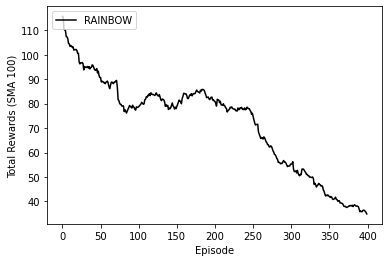

In [ ]:
window = 100
plt.xlabel('Episode')
plt.ylabel('Total Rewards (SMA 100)')
#plt.plot([np.mean(agent.total_rewards[tr:tr+window]) for tr in range(len(agent.total_rewards)-window)],'blue',label='DQN')
#plt.plot([np.mean(per_agent.total_rewards[tr:tr+window]) for tr in range(len(per_agent.total_rewards)-window)],'green',label='DQN with PER')
#plt.plot([np.mean(dueling_agent.total_rewards[tr:tr+window]) for tr in range(len(dueling_agent.total_rewards)-window)],'red',label='Dueling DQN')
#plt.plot([np.mean(double_agent.total_rewards[tr:tr+window]) for tr in range(len(double_agent.total_rewards) - window)],'orange',label=' Double DQN')
#plt.plot([np.mean(n_step_agent.total_rewards[tr:tr+window]) for tr in range(len(n_step_agent.total_rewards) - window)],'magenta',label='N-Step DQN')
plt.plot([np.mean(rainbow_agent.total_rewards[tr:tr+window]) for tr in range(len(rainbow_agent.total_rewards) - window)],'black',label='RAINBOW')
plt.legend(loc='upper left')
plt.savefig('CompiledChartsSpaceInvaders.png')
plt.show()